In [1]:
import warnings
import pandas as pd
import numpy as np
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
from IPython.display import display
from woe_scoring import WOETransformer, CreateModel
from typing import Union
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, precision_score, recall_score
from sklearn.model_selection import train_test_split, GridSearchCV
import statsmodels.api as sm
from tqdm import tqdm
import gc

import pymssql
import sqlalchemy as sa
import pandas.io.sql as psql 
import hashlib
import csv
gc.collect()
df = pd.read_csv("final_full_clfrombroker_excl.csv", sep=";", on_bad_lines='skip')

In [2]:
df['target'] = df['OBJECT'].apply(lambda x: 0 if pd.isna(x) else 1)
df = df.drop(['OBJECT'], axis=1)
df = df.fillna(value=np.nan)
df.head(1)

,RTDM_ID,LIMIT_REQUESTED,SALE_CHANNEL,ATTRACTION_CHANNEL,ROW_DATE,DATE_INS_UPD,RTDM_ID.1,QUERYID,REQUESTID,DATENTER,...,CLIENT_LEGALIZ.1,CLIENT_BL_FM.1,CLIENT_OFAC.1,CLIENT_HAS_DIGITAL_PROFILE.1,CLIENT_FSD.1,CLIENT_DIGITAL_PROFILE_DATE.1,CLIENT_CATEGORY.1,CLIENT_INCOME_ANNOUNCED.1,CLIENT_ARBITRTYPE.1,target
0,50872493,"100000,00",17,18,1,"05.04.22 18:03:37,446718",50872493.0,104021004.0,390961251.0,01.01.2022 0:04:13,...,0.0,NaN,0,0.0,0,NaN,NaN,NaN,NaN,0


In [3]:
df_dop = pd.read_csv("F_N2B_F_N2BKI_clfrombroker.csv", sep=";", on_bad_lines='skip')
df = df.merge(df_dop, how='left', on='RTDM_ID')
del df_dop

In [4]:
obj_columns = [
'INTEGRAL_SCORE_V2',
'BRS_CARD_SCORE_1',
'BRS_CASH_SCORE_1',
'BRS_CASH_SCORE_2020_02',
'INCOME_5_MODEL_201912_PROB0',
'INCOME_5_MODEL_201912_PROB1',
'INCOME_5_MODEL_201912_PROB2',
'INCOME_5_MODEL_201912_PROB3',
'INCOME_5_MODEL_201912_PROB4',
'BRS_CASH_SCORE_90_16_2021_02',
'BRS_CASH_SCORE_30_6_2021_02',
'BRS_CC_SCORE_202012',
'LIMIT_REQUESTED',
'CLIENT_PERS1', 
'CLIENT_PERS1_CONFIRMED'
]
for i in obj_columns:
     df[i] = df[i].astype(str).str.replace(',', '.')
     df[i] = df[i].astype(float)

df['OPERATOR.2'] = df['OPERATOR.2'].astype(str)
df['REGION.2'] = df['REGION.2'].astype(str)
df['OPERATOR.1'] = df['OPERATOR.1'].astype(str)
df['REGION.1'] = df['REGION.1'].astype(str)
df['OPERATOR'] = df['OPERATOR'].astype(str)
df['REGION'] = df['REGION'].astype(str)
df["CLIENT_MARRIED"] = df["CLIENT_MARRIED"].astype(str)
df["CLIENT_POL"] = df["CLIENT_POL"].astype(str)
#df['CLIENT_PERS1'] = df['CLIENT_PERS1'].astype(str)
#df['CLIENT_PERS1_CONFIRMED'] = df['CLIENT_PERS1_CONFIRMED'].astype(str)

df["POL_MARRIED"] = df["CLIENT_MARRIED"] + df["CLIENT_POL"]
#df["POL_CHILDREN"] = df["CLIENT_CHILDREN"] + df["CLIENT_POL"]
df['FL_MOBILE_PHONE'] = df['CLIENT_KONTAKT_MOBIL_TEL'].apply(lambda x : 1 if pd.notnull(x) else 0)
df['FL_REG_PHONE'] = df['CLIENT_KONTAKT_DOM_TEL'].apply(lambda x : 1 if pd.notnull(x) else 0) 
df['FL_WORK_PHONE'] = df['CLIENT_KONTAKT_WORK_TEL'].apply(lambda x : 1 if pd.notnull(x) else 0) 
df['FL_EMAIL'] = df['CLIENT_EMAIL'].apply(lambda x : 1 if pd.notnull(x) else 0) 
df['LIMIT_PERS1'] = df['LIMIT_REQUESTED'] / df['CLIENT_PERS1'] 

In [5]:
df['DATREQUEST'] = pd.to_datetime(df['DATREQUEST'], format='mixed')
df['rdate'] = df['DATREQUEST'].dt.strftime('%Y%m')
df['rdate'] = pd.to_numeric(df['rdate'], errors='coerce')

In [6]:
res_df = df[["F_N2B",
             "F_N2BKI",
             'LIMIT_PERS1',
             "CLIENT_MARRIED",
             "CLIENT_POL",
    
            'RTDM_ID',
            'LIMIT_REQUESTED',
            'SALE_CHANNEL',	
            'ATTRACTION_CHANNEL',	
            'ROW_DATE',	
            'DATE_INS_UPD',	
            'RTDM_ID.1',	
            'QUERYID',	
            'REQUESTID',	
            'DATENTER',	
            'DATREQUEST',	
            'PHONE',	
            'ALL_CLC',
            'target',
            'BLOCK_CNT',	
            'BLOCK_DUR',	
            'CIRCLE',	
            'PAY_MAX',	
            'VOICE_CALL_OUT_D28',	
            'IS_SMARTPHONE',	
            'DEVICE_OWNER_CHANGE',	
            'IS_MEGAFON_DOUBLE',	
            'INTEGRAL_SCORE_V2',	
            'BRS_CARD_SCORE_1',	
            'BRS_CASH_SCORE_1',

            'IS_HOME100_V1',	
            'IS_HOME100_V2',	
            'IS_HOME500_V1',	
            'IS_HOME500_V2',	
            'IS_HOME1000_V1',	
            'IS_HOME1000_V2',	
            'IS_HOME2000_V1',	
            'IS_HOME2000_V2',	
            'IS_WORK100_V1',	
            'IS_WORK100_V2',	
            'IS_WORK500_V1',	
            'IS_WORK500_V2',	
            'IS_WORK1000_V1',	
            'IS_WORK1000_V2',	
            'IS_WORK2000_V1',	
            'IS_WORK2000_V2',	
            'HOME_DIST_CATEGORY',	
            'WORK_DIST_CATEGORY',	
            'POI_DIST_CATEGORY',

            'BRS_CASH_SCORE_2020_02',	
            'SUCCESS_AF_G_CALLS_COUNT_D28',	
            'SUCCESS_AF_G_PHONES_COUNT_D28',	
            'INCOME_5_MODEL_201912_SCORE',	
            'INCOME_5_MODEL_201912_PROB0',	
            'INCOME_5_MODEL_201912_PROB1',	
            'INCOME_5_MODEL_201912_PROB2',	
            'INCOME_5_MODEL_201912_PROB3',	
            'INCOME_5_MODEL_201912_PROB4',	
            'BRS_CASH_SCORE_90_16_2021_02',	
            'BRS_CASH_SCORE_30_6_2021_02',	
            'BRS_CC_SCORE_202012',

            'DATE_INS_UPD.1',	
            'RTDM_ID.2',	
            'DATENTER.1',	
            'DATREQUEST.1',	
            'PHONE.1',	
            'ALL_CLC.1',	
            'BLOCK_CNT.1',	
            'BLOCK_DUR.1',	
            'CIRCLE.1',	
            'PAY_MAX.1',	
            'VOICE_CALL_OUT_D28.1',	
            'IS_SMARTPHONE.1',	
            'DEVICE_OWNER_CHANGE.1',	
            'IS_MEGAFON_DOUBLE.1',

            'DATE_INS_UPD.2',	
            'RTDM_ID.3',	
            'DATENTER.2',	
            'DATREQUEST.2',	
            'PHONE.2',	
            'ALL_CLC.2',	
            'BLOCK_CNT.2',	
            'BLOCK_DUR.2',	
            'CIRCLE.2',	
            'PAY_MAX.2',	
            'VOICE_CALL_OUT_D28.2',	
            'IS_SMARTPHONE.2',	
            'DEVICE_OWNER_CHANGE.2',	
            'IS_MEGAFON_DOUBLE.2',
            'OPERATOR.2',
            'REGION.2',
            'OPERATOR.1',
            'REGION.1',
            'OPERATOR',
            'REGION',
            'rdate',
            #"CLIENT_PNKI",
            #"CLIENT_SEGMENT",
            #"CLIENT_BKI_AGREE",
            "CLIENT_EDUCATION",
            "CLIENT_WORK_TIME_OPS",
            "CLIENT_WORK_OTRASLE",
            "CLIENT_WORK_DOLJN",
            "CLIENT_WORK_TIME_ORIENTIR",
            "CLIENT_PERS1",               #не категориальный
            #"CLIENT_PERS1_CONFIRMED",     #не категориальный
            #"CLIENT_BL_DOC",
            #"CLIENT_ADD_STATE",
            #"CLIENT_BL_CLIENTS",
            "CLIENT_WORK_TYPE",
            "CLIENT_WORK_FORM_GOS",
            "CLIENT_WORK_FORM_COMMERC",
          #   "CLIENT_PP_LIVE",
          #   "CLIENT_RC_LIVE",
          #   "CLIENT_RP_LIVE",
          #   "CLIENT_RC_REG",
          #   "CLIENT_RP_REG",
          #   "CLIENT_PP_REG",
            #"CLIENT_SMS_SERVICE",
            #"CLIENT_WORK_KOD",
            "CLIENT_AGE",    
            "CLIENT_IS_NEW",
            #"CLIENT_IS_NEW_BRS6MOVER24M",
            "CLIENT_IS_NEW_36M",
            "CLIENT_IS_BUSINESSMAN",
            #"CLIENT_HASTRIGGEROKB",
            #"CLIENT_HASTRIGGERNBKI",
            #"CLIENT_IS_BANKRUPT2",
            #"CLIENT_DBO",
            "CLIENT_TERRORIST",
            #"CLIENT_LEGALIZ",
            #"CLIENT_BL_FM",
            #"CLIENT_OFAC",
            #"CLIENT_HAS_DIGITAL_PROFILE",
            #"CLIENT_FSD",
            #"CLIENT_DIGITAL_PROFILE_DATE",
            #"CLIENT_CATEGORY",
            #"CLIENT_INCOME_ANNOUNCED",
            #"CLIENT_ARBITRTYPE",
            "POL_MARRIED",
            #"POL_CHILDREN",
            "CLIENT_CHILDREN",
            'FL_MOBILE_PHONE',
            'FL_REG_PHONE',
            'FL_WORK_PHONE',
            'FL_EMAIL'
                   ]]

cat_cols = [
            "F_N2B",
             "F_N2BKI",
             "POL_MARRIED",
             "CLIENT_MARRIED",
             "CLIENT_POL",
            #"POL_CHILDREN",
            'FL_MOBILE_PHONE',
            'FL_REG_PHONE',
            'FL_WORK_PHONE',
            'FL_EMAIL',
            #"CLIENT_BL_DOC",
            #"CLIENT_ADD_STATE",
            #"CLIENT_BL_CLIENTS",
            "CLIENT_WORK_TYPE",
            "CLIENT_WORK_FORM_GOS",
            "CLIENT_WORK_FORM_COMMERC",
       #      "CLIENT_PP_LIVE",
       #      "CLIENT_RC_LIVE",
       #      "CLIENT_RP_LIVE",
       #      "CLIENT_RC_REG",
       #      "CLIENT_RP_REG",
       #      "CLIENT_PP_REG",
            #"CLIENT_SMS_SERVICE",    
            #"CLIENT_PNKI",
            #"CLIENT_SEGMENT",
            #"CLIENT_BKI_AGREE",
            #"CLIENT_EDUCATION",
            "CLIENT_WORK_TIME_OPS",
            "CLIENT_WORK_OTRASLE",
            "CLIENT_WORK_DOLJN",
            "CLIENT_WORK_TIME_ORIENTIR",       
            #"CLIENT_IS_BANKRUPT2",
            #"CLIENT_DBO",
            "CLIENT_TERRORIST",
            #"CLIENT_LEGALIZ",
            #"CLIENT_BL_FM",
            #"CLIENT_OFAC",
            #"CLIENT_HAS_DIGITAL_PROFILE",
            #"CLIENT_FSD",
            #"CLIENT_DIGITAL_PROFILE_DATE",
            #"CLIENT_CATEGORY",
            #"CLIENT_INCOME_ANNOUNCED",
            #"CLIENT_ARBITRTYPE",
            "CLIENT_IS_BUSINESSMAN",
            #"CLIENT_HASTRIGGEROKB",
            #"CLIENT_HASTRIGGERNBKI",
            "CLIENT_IS_NEW",
            #"CLIENT_IS_NEW_BRS6MOVER24M",
            "CLIENT_IS_NEW_36M",   
            #"CLIENT_WORK_KOD",

            'ALL_CLC',
            'SALE_CHANNEL',	
            'ATTRACTION_CHANNEL',
            #'BLOCK_CNT',	
            'BLOCK_DUR',	
            'CIRCLE',	
            'PAY_MAX',	
            'VOICE_CALL_OUT_D28',	
            'IS_SMARTPHONE',	
            'DEVICE_OWNER_CHANGE',	
            'IS_MEGAFON_DOUBLE',
            'IS_HOME100_V1',	
            'IS_HOME100_V2',	
            'IS_HOME500_V1',	
            'IS_HOME500_V2',	
            'IS_HOME1000_V1',	
            'IS_HOME1000_V2',	
            'IS_HOME2000_V1',	
            'IS_HOME2000_V2',	
            'IS_WORK100_V1',	
            'IS_WORK100_V2',	
            'IS_WORK500_V1',	
            'IS_WORK500_V2',	
            'IS_WORK1000_V1',	
            'IS_WORK1000_V2',	
            'IS_WORK2000_V1',	
            'IS_WORK2000_V2',	
            'HOME_DIST_CATEGORY',	
            'WORK_DIST_CATEGORY',	
            'POI_DIST_CATEGORY',
            'SUCCESS_AF_G_CALLS_COUNT_D28',	
            'SUCCESS_AF_G_PHONES_COUNT_D28',
            'ALL_CLC_kt',	
            #'BLOCK_CNT_kt',	
            'BLOCK_DUR_kt',	
            'CIRCLE_kt',	
            'PAY_MAX_kt',	
            'VOICE_CALL_OUT_D28_kt',	
            'IS_SMARTPHONE_kt',	
            'DEVICE_OWNER_CHANGE_kt',	
            'IS_MEGAFON_DOUBLE_kt',
            'ALL_CLC_rt',	
            #'BLOCK_CNT_rt',	
            'BLOCK_DUR_rt',	
            'CIRCLE_rt',	
            'PAY_MAX_rt',	
            'VOICE_CALL_OUT_D28_rt',	
            'IS_SMARTPHONE_rt',	
            'DEVICE_OWNER_CHANGE_rt',	
            'IS_MEGAFON_DOUBLE_rt',
            'OPERATOR_rt',
            'REGION_rt',
            'OPERATOR_kt',
            'REGION_kt',
            'OPERATOR',
            'REGION',
            #'CLIENT_PERS1',
            #'CLIENT_PERS1_CONFIRMED'

            ]
flags = ['target']
special_cols = [ 
            'RTDM_ID',           
            'ROW_DATE',	
            'DATE_INS_UPD',	
            'RTDM_ID.1',	
            'QUERYID',	
            'REQUESTID',	
            'DATENTER',	
            'DATREQUEST',	
            'PHONE',
            'DATE_INS_UPD_kt',	
            'RTDM_ID.2',	
            'DATENTER_kt',	
            'DATREQUEST_kt',	
            'PHONE_kt',
         #   'DATE_INS_UPD_rt',	
            'RTDM_ID.3',	
            'DATENTER_rt',	
            'DATREQUEST_rt',	
            'DATE_INS_UPD_base',
            'PHONE_rt',	
            #'CLIENT_DIGITAL_PROFILE_DATE',
            'rdate'	
            ] + flags

In [7]:
#df.head(100).to_excel('123.xlsx')
#[col for col in res_df.columns if col.endswith('.2')]
res_df = res_df.rename(columns={
 'DATE_INS_UPD.1': 'DATE_INS_UPD_base',
 'DATENTER.1': 'DATENTER_kt',
 'DATREQUEST.1': 'DATREQUEST_kt',
 'PHONE.1': 'PHONE_kt',
 'ALL_CLC.1': 'ALL_CLC_kt',
 'BLOCK_CNT.1': 'BLOCK_CNT_kt',
 'BLOCK_DUR.1': 'BLOCK_DUR_kt',
 'CIRCLE.1': 'CIRCLE_kt',
 'PAY_MAX.1': 'PAY_MAX_kt',
 'VOICE_CALL_OUT_D28.1': 'VOICE_CALL_OUT_D28_kt',
 'IS_SMARTPHONE.1': 'IS_SMARTPHONE_kt',
 'DEVICE_OWNER_CHANGE.1': 'DEVICE_OWNER_CHANGE_kt',
 'IS_MEGAFON_DOUBLE.1': 'IS_MEGAFON_DOUBLE_kt',
 'OPERATOR.1': 'OPERATOR_kt',
 'REGION.1': 'REGION_kt',
 'DATE_INS_UPD.2': 'DATE_INS_UPD_kt',
 'DATE_INS_UPD.3': 'DATE_INS_UPD_rt',
 'DATENTER.2': 'DATENTER_rt',
 'DATREQUEST.2': 'DATREQUEST_rt',
 'PHONE.2': 'PHONE_rt',
 'ALL_CLC.2': 'ALL_CLC_rt',
 'BLOCK_CNT.2': 'BLOCK_CNT_rt',
 'BLOCK_DUR.2': 'BLOCK_DUR_rt',
 'CIRCLE.2': 'CIRCLE_rt',
 'PAY_MAX.2': 'PAY_MAX_rt',
 'VOICE_CALL_OUT_D28.2': 'VOICE_CALL_OUT_D28_rt',
 'IS_SMARTPHONE.2': 'IS_SMARTPHONE_rt',
 'DEVICE_OWNER_CHANGE.2': 'DEVICE_OWNER_CHANGE_rt',
 'IS_MEGAFON_DOUBLE.2': 'IS_MEGAFON_DOUBLE_rt',
 'OPERATOR.2': 'OPERATOR_rt',
 'REGION.2': 'REGION_rt'
})

In [24]:
res_df.drop(special_cols, axis=1).head()

,F_N2B,F_N2BKI,LIMIT_PERS1,CLIENT_MARRIED,CLIENT_POL,LIMIT_REQUESTED,SALE_CHANNEL,ATTRACTION_CHANNEL,ALL_CLC,BLOCK_CNT,...,CLIENT_IS_NEW,CLIENT_IS_NEW_36M,CLIENT_IS_BUSINESSMAN,CLIENT_TERRORIST,POL_MARRIED,CLIENT_CHILDREN,FL_MOBILE_PHONE,FL_REG_PHONE,FL_WORK_PHONE,FL_EMAIL
0,0.0,0.0,1.666667,1,2,100000.0,17,18,3.0,0.0,...,1,1,0.0,0,12,3,1,0,1,1
1,0.0,0.0,1.000000,2,1,300000.0,17,18,3.0,0.0,...,1,1,0.0,0,21,1,1,1,1,1
2,1.0,0.0,6.461538,1,2,420000.0,17,18,1.0,0.0,...,0,0,0.0,0,12,2,1,1,0,1
3,0.0,0.0,8.333333,2,2,500000.0,17,18,NaN,NaN,...,1,1,NaN,0,22,1,1,0,1,0
4,0.0,0.0,8.571429,2,1,300000.0,17,18,1.0,0.0,...,1,1,0.0,0,21,1,1,0,1,1


In [8]:
#res_df.drop(special_cols, axis=1).head().to_excel('head_of_fin.xlsx')
#res_df[(res_df['target'] == 1)].shape[0]/res_df.shape[0]
#res_df.iloc[:, df.isnull().all()]
# a = res_df.drop(labels=cat_cols, axis=1)
# a.drop(labels=special_cols, axis=1).select_dtypes(exclude=['int', 'float']).columns
#list(special_cols).append(list(cat_cols))
#res_df.drop(labels=special_cols, axis=1).select_dtypes(exclude=['int', 'float']).columns
train, test = train_test_split(
    res_df, test_size=0.25, random_state=4, stratify=res_df['target'])

In [9]:
encoder = WOETransformer(
    max_bins=8,
    min_pct_group=0.05,             
    cat_features=cat_cols,
    special_cols=special_cols,
    
    diff_woe_threshold=0.05,         
    safe_original_data=False,
    )
encoder.fit(train, train['target'])

In [10]:
enc_train = encoder.transform(train)
enc_test = encoder.transform(test)
enc_train.head(1)

,RTDM_ID,ROW_DATE,DATE_INS_UPD,RTDM_ID.1,QUERYID,REQUESTID,DATENTER,DATREQUEST,PHONE,target,...,WOE_INCOME_5_MODEL_201912_PROB4,WOE_BRS_CASH_SCORE_90_16_2021_02,WOE_BRS_CASH_SCORE_30_6_2021_02,WOE_BRS_CC_SCORE_202012,WOE_BLOCK_CNT_kt,WOE_BLOCK_CNT_rt,WOE_CLIENT_EDUCATION,WOE_CLIENT_PERS1,WOE_CLIENT_AGE,WOE_CLIENT_CHILDREN
329611,53964872,1,"19.05.22 09:09:36,851891",53964872.0,108705007.0,411233350.0,18.05.2022 18:50:56,2022-05-18 18:57:10,9.017156e+09,0,...,-0.209965,0.142652,-0.063697,0.198052,-0.016435,-0.393474,-0.284886,-0.310183,0.031369,-0.000001


In [11]:
del train, test
del res_df

In [29]:
enc_test.drop(special_cols, axis=1).columns.to_frame().to_csv('final_columns_woe_lr_231113-v2.txt', index=False)

In [12]:

gc.collect()
model_sfs = CreateModel(
    model_type = 'sklearn',
    selection_method='sfs',  
    iv_threshold=0.001,   #0.001    
    max_vars=30, #0.99, 
    random_state=42,
    cv=3, #3
    class_weight="balanced",
    special_cols=special_cols,
    l1_exp_scale=5, #4
    l1_grid_size=25, #25
    n_jobs=-1,
)

model_sfs.fit(enc_train, enc_train["target"]) 

tmp_df_iv = pd.DataFrame({
    'features': model_sfs.feature_names_,
    'coef': list(model_sfs.coef_)
})
tmp_df_iv

,features,coef
0,WOE_CIRCLE,-0.447946
1,WOE_FL_EMAIL,-0.109818
2,WOE_CLIENT_WORK_TIME_OPS,-0.309834
3,WOE_REGION_rt,-0.508214
4,WOE_ATTRACTION_CHANNEL,-0.831452
5,WOE_LIMIT_REQUESTED,-0.555209
6,WOE_CLIENT_WORK_DOLJN,-0.373591
7,WOE_VOICE_CALL_OUT_D28_rt,-0.266047
8,WOE_REGION,-0.629604
9,WOE_FL_REG_PHONE,-0.545757


In [ ]:
model_sfs.save_scorecard(encoder)

AttributeError: 'CreateModel' object has no attribute 'model_results'

In [ ]:
model_sfs.generate_sql(encoder)

"with a as (SELECT REGION,FL_REG_PHONE,F_N2B,ATTRACTION_CHANNEL,FL_EMAIL,CLIENT_WORK_DOLJN,CLIENT_WORK_OTRASLE,CLIENT_WORK_TIME_OPS,CLIENT_PERS1,CLIENT_EDUCATION,LIMIT_REQUESTED,REGION_rt,BRS_CASH_SCORE_30_6_2021_02, CASE WHEN REGION in ('Архангельская обл.', 'Тверская обл.', 'Чувашская Республика', 'Костромская обл.', 'Тульская обл.', 'Удмуртская Республика', 'Республика Мордовия', 'Алтайский край', 'Астраханская обл.', 'Волгоградская обл.', 'Воронежская обл.', 'Иркутская обл.', 'Омская обл.', 'Архангельская область * Ненецкий автономный округ', 'Еврейская автономная обл.', 'Забайкальский край', 'Кемеровская область - Кузбасс', 'Ненецкий АО', 'Новгородская обл.', 'Республика Бурятия', 'Республика Кабардино-Балкарская', 'Республика Карачаево-Черкесская', 'Республика Крым * г. Севастополь', 'Республика Крым и г. Севастополь', 'Республика Тыва', 'Республика Удмуртская', 'Республика Чеченская', 'Сахалинская обл.', 'Херсонская обл.', 'Чувашская Республика - Чувашия', 'Чукотский АО', 'г. Мо

In [13]:
new_features_iv = tmp_df_iv[tmp_df_iv['coef'] < 0]['features'].to_list()
new_features_iv

['WOE_CIRCLE',
 'WOE_FL_EMAIL',
 'WOE_CLIENT_WORK_TIME_OPS',
 'WOE_REGION_rt',
 'WOE_ATTRACTION_CHANNEL',
 'WOE_LIMIT_REQUESTED',
 'WOE_CLIENT_WORK_DOLJN',
 'WOE_VOICE_CALL_OUT_D28_rt',
 'WOE_REGION',
 'WOE_FL_REG_PHONE',
 'WOE_CLIENT_PERS1',
 'WOE_CIRCLE_kt',
 'WOE_CLIENT_EDUCATION',
 'WOE_F_N2B',
 'WOE_BRS_CASH_SCORE_30_6_2021_02',
 'WOE_IS_WORK2000_V2',
 'WOE_CLIENT_WORK_OTRASLE']

In [14]:
train_prediction = model_sfs.predict_proba(enc_train[new_features_iv])[:,1]  
test_prediction = model_sfs.predict_proba(enc_test[new_features_iv])[:,1]  

enc_train['prediction'] = train_prediction 
enc_test['prediction'] = test_prediction 

roc_auc_train = roc_auc_score(enc_train['target'], train_prediction)
roc_auc_test = roc_auc_score(enc_test['target'], test_prediction)

[(2*roc_auc_train-1)*100, (2*roc_auc_test-1)*100]

[78.90367159390948, 76.80151625322924]

In [30]:
gc.collect
import scipy.stats as stats
dict_to_stats = {
    "feature_name": [],
    "chi2": [],
    "p_value": []
} 
tmp_enc_df = pd.concat([enc_train, enc_test]).reset_index(drop=True)

tmp_enc_df = tmp_enc_df[model_sfs.feature_names_ ]

for i in model_sfs.feature_names_[:len(model_sfs.feature_names_)-1]:
    contingency_table = pd.crosstab(tmp_enc_df[i], tmp_enc_df['target'])
    res = stats.chi2_contingency(contingency_table)
    p_value = res.pvalue
    chi2 = res.statistic
    #chi2, p_value, _, _ = stats.chi2_contingency(contingency_table)
    dict_to_stats["feature_name"].append(i)
    dict_to_stats["chi2"].append(chi2)
    dict_to_stats["p_value"].append(p_value)

df_stats_chi2_pv = pd.DataFrame(dict_to_stats)
df_stats_chi2_pv = df_stats_chi2_pv.merge(tmp_df_iv, left_on="feature_name", right_on="features")
df_stats_chi2_pv 

,feature_name,chi2,p_value,features,coef
0,WOE_CIRCLE,39.639120,1.270707e-08,WOE_CIRCLE,-0.447946
1,WOE_FL_EMAIL,821.939846,9.162700e-181,WOE_FL_EMAIL,-0.109818
2,WOE_CLIENT_WORK_TIME_OPS,967.235433,2.304883e-209,WOE_CLIENT_WORK_TIME_OPS,-0.309834
3,WOE_REGION_rt,1993.957925,0.000000e+00,WOE_REGION_rt,-0.508214
4,WOE_ATTRACTION_CHANNEL,7892.350337,0.000000e+00,WOE_ATTRACTION_CHANNEL,-0.831452
5,WOE_LIMIT_REQUESTED,2596.832364,0.000000e+00,WOE_LIMIT_REQUESTED,-0.555209
6,WOE_CLIENT_WORK_DOLJN,421.518937,2.939855e-92,WOE_CLIENT_WORK_DOLJN,-0.373591
7,WOE_VOICE_CALL_OUT_D28_rt,379.753687,1.407951e-84,WOE_VOICE_CALL_OUT_D28_rt,-0.266047
8,WOE_REGION,1398.963946,1.159407e-301,WOE_REGION,-0.629604
9,WOE_FL_REG_PHONE,400.702009,3.873615e-89,WOE_FL_REG_PHONE,-0.545757


In [32]:
df_stats_chi2_pv.drop(columns='features').to_excel('df_stats_chi2_pv.xlsx')

In [24]:
tmp_enc_df[model_sfs.feature_names_ ]

,WOE_CIRCLE,WOE_FL_EMAIL,WOE_CLIENT_WORK_TIME_OPS,WOE_REGION_rt,WOE_ATTRACTION_CHANNEL,WOE_LIMIT_REQUESTED,WOE_CLIENT_WORK_DOLJN,WOE_VOICE_CALL_OUT_D28_rt,WOE_REGION,WOE_FL_REG_PHONE,WOE_CLIENT_PERS1,WOE_CIRCLE_kt,WOE_CLIENT_EDUCATION,WOE_F_N2B,WOE_BRS_CASH_SCORE_30_6_2021_02,WOE_IS_WORK2000_V2,WOE_CLIENT_WORK_OTRASLE,target
0,-0.085354,-0.366817,0.355655,-0.739134,-1.370943,-0.015162,0.448215,-0.405630,-0.150692,-0.154100,-0.310183,-0.184330,-0.284886,0.244015,-0.063697,-0.136003,-0.038646,0
1,0.103986,0.715257,-0.643832,-0.739134,1.392788,-0.015162,0.007328,-0.405630,-0.817361,-0.154100,0.085067,-0.037399,0.226321,0.244015,0.242086,0.229680,-0.101055,0
2,-0.085354,-0.366817,-0.643832,-0.739134,1.392788,-1.125662,0.007328,0.249199,-0.150692,-0.154100,-0.310183,-0.037399,-0.284886,0.244015,-0.169647,-0.136003,-0.038646,0
3,0.183263,-0.366817,-0.467571,0.741507,1.392788,0.085385,0.007328,-0.405630,0.799660,-0.154100,0.170995,0.200265,0.226321,0.244015,-0.063697,-0.288679,-0.038646,0
4,0.183263,-0.366817,-0.467571,0.741507,-1.370943,-1.125662,0.007328,0.249199,-0.150692,1.105001,-0.310183,0.200265,0.226321,0.244015,0.177975,-0.136003,0.289634,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1335417,0.183263,-0.366817,0.355655,-0.739134,1.392788,0.425918,0.007328,-0.405630,0.290779,-0.154100,-0.310183,-0.184330,-0.284886,0.244015,-0.063697,-0.136003,0.289634,0
1335418,-0.085354,-0.366817,0.355655,0.741507,1.392788,-0.015162,0.448215,0.249199,-0.150692,-0.154100,-0.389836,0.200265,0.226321,0.244015,-0.487244,0.229680,-0.101055,0
1335419,0.103986,-0.366817,0.355655,-0.739134,1.392788,-0.015162,0.007328,0.249199,-0.817361,-0.154100,-0.234766,-0.037399,-0.284886,0.244015,0.602553,-0.136003,0.289634,0
1335420,0.183263,0.715257,0.355655,-0.739134,1.392788,0.998779,0.007328,0.249199,-0.150692,-0.154100,0.170995,0.200265,0.226321,0.244015,-0.063697,-0.136003,-0.568539,0


In [16]:
enc_train

,RTDM_ID,ROW_DATE,DATE_INS_UPD,RTDM_ID.1,QUERYID,REQUESTID,DATENTER,DATREQUEST,PHONE,target,...,WOE_BRS_CASH_SCORE_90_16_2021_02,WOE_BRS_CASH_SCORE_30_6_2021_02,WOE_BRS_CC_SCORE_202012,WOE_BLOCK_CNT_kt,WOE_BLOCK_CNT_rt,WOE_CLIENT_EDUCATION,WOE_CLIENT_PERS1,WOE_CLIENT_AGE,WOE_CLIENT_CHILDREN,prediction
329611,53964872,1,"19.05.22 09:09:36,851891",53964872.0,108705007.0,411233350.0,18.05.2022 18:50:56,2022-05-18 18:57:10,9.017156e+09,0,...,0.142652,-0.063697,0.198052,-0.016435,-0.393474,-0.284886,-0.310183,0.031369,-0.000001,0.896706
489661,55544864,1,"23.07.22 09:13:03,792675",55544864.0,111365294.0,422633459.0,22.07.2022 15:41:28,2022-07-22 15:48:50,9.219793e+09,0,...,0.366165,0.242086,0.198052,-0.016435,0.092775,0.226321,0.085067,0.031369,-0.000001,0.383833
1176275,67128778,1,"07.07.23 09:18:47,998032",67128778.0,142465682.0,527591119.0,01.07.2023 10:57:13,2023-01-07 10:58:52,9.194114e+09,0,...,0.142652,-0.169647,0.198052,-0.016435,-0.393474,-0.284886,-0.310183,0.031369,-0.000001,0.681485
1152625,66579868,1,"20.06.23 09:15:30,790911",66579868.0,141636849.0,522774550.0,18.06.2023 11:12:04,2023-06-18 11:16:11,9.374156e+09,0,...,0.366165,-0.063697,0.198052,0.049937,0.092775,0.226321,0.170995,-0.177555,-0.000001,0.149642
1113976,65595270,1,"25.05.23 10:18:14,609756",65595270.0,140412961.0,514487885.0,24.05.2023 15:12:24,2023-05-24 15:12:44,9.130055e+09,0,...,-0.083209,0.177975,0.061497,0.049937,0.092775,0.226321,-0.310183,0.031369,-0.000001,0.698918
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58053,51455110,1,"05.04.22 18:07:47,492684",51455110.0,104882556.0,394754923.0,25.01.2022 14:52:44,2022-01-25 15:10:18,9.210141e+09,0,...,0.366165,0.602553,0.357447,-0.016435,-0.393474,0.226321,0.462692,0.031369,-0.000001,0.062225
921993,61734260,1,"19.02.23 09:45:27,462772",61734260.0,122031122.0,468445074.0,15.02.2023 22:00:28,2023-02-16 09:28:39,9.515108e+09,0,...,0.142652,0.177975,0.357447,-0.016435,0.092775,0.226321,-0.389836,0.031369,-0.000001,0.100572
777437,59486310,1,"04.12.22 09:25:36,145550",59486310.0,118522809.0,451011071.0,03.12.2022 15:11:26,2022-03-12 15:17:43,9.508239e+09,0,...,0.273917,-0.169647,0.357447,-0.016435,0.092775,0.226321,0.170995,0.031369,-0.000001,0.125735
1218609,68171697,1,"01.08.23 09:24:12,506009",68171697.0,143750380.0,536077317.0,26.07.2023 19:26:47,2023-07-26 19:36:04,9.527597e+09,0,...,0.142652,0.352827,0.061497,-0.016435,0.092775,-0.284886,0.085067,0.031369,-0.000001,0.468967


In [80]:
res_dict = {
    'rdate': [],
    'cnt_all': [],
    'cnt_bad_targ': [],
    'bad_rate_targ': [], 
    'cnt_bad_pred': [],
    'bad_rate_pred': [], 
}

for i, date in enumerate(enc_train[(enc_train['rdate']<202210)]['rdate'].sort_values().unique()):
    res_dict['rdate'].append(date)
    res_dict['cnt_all'].append(enc_test[enc_test['rdate'] == date].shape[0])
    res_dict['cnt_bad_targ'].append(enc_test[(enc_test['rdate'] == date) 
                                         & (enc_test['target'] == 1)].shape[0]) 
    res_dict['bad_rate_targ'].append(res_dict['cnt_bad_targ'][i] / res_dict['cnt_all'][i])   
    res_dict['cnt_bad_pred'].append(enc_test[(enc_test['rdate'] == date) 
                                         & (enc_test['prediction'] >= 0.9678683484503049)].shape[0]) 
    res_dict['bad_rate_pred'].append(res_dict['cnt_bad_pred'][i] / res_dict['cnt_all'][i])   
bad_rates = pd.DataFrame.from_dict(res_dict)
bad_rates

,rdate,cnt_all,cnt_bad_targ,bad_rate_targ,cnt_bad_pred,bad_rate_pred
0,202201.0,18611,55,0.002955,35,0.001881
1,202202.0,12529,33,0.002634,30,0.002394
2,202203.0,17260,37,0.002144,18,0.001043
3,202204.0,18336,33,0.001800,18,0.000982
4,202205.0,21537,52,0.002414,35,0.001625
5,202206.0,16373,57,0.003481,17,0.001038
6,202207.0,16313,61,0.003739,29,0.001778
7,202208.0,15564,49,0.003148,21,0.001349
8,202209.0,14756,39,0.002643,25,0.001694


In [102]:
stat_test_1 = enc_test
stat_test_1.sort_values(by='prediction', inplace=True)
# num_groups = len(df) // 150
# rem = len(df) % 150
# sizes = [150] * num_groups + [rem] if rem != 0 else []
# stat_test_1['bins'] = sum([[i + 1] * sizes[i] for i in range(len(sizes))], [])
bins = [0]
#stat_test_1['bins'] =  np.repeat(range(len(stat_test_1) // 338 + 1), 338)[:len(stat_test_1)]
bins.extend(
    pd.DataFrame(stat_test_1['prediction'].sort_values()).quantile(q / 1500)[0] for q in range(1, 1500))
bins.append(1)
# stat_test_1['bins']=''
# for i in range(len(bins)):
stat_test_1['bins'] = pd.cut(stat_test_1['prediction'], bins=bins, labels=False, include_lowest=True)
stat_test_1['bins'] = stat_test_1['bins'].apply(lambda x: f"{bins[x]}-{bins[x+1]}")
stat_test_1
        



# stat_test_1['bins'] = np.repeat(range(len(stat_test_1) // 1000 + 1), 1000)[:len(stat_test_1)]
test_first = stat_test_1.groupby('bins').agg({'prediction' : lambda x: (x.min(), x.max()), 'target': ['count', 'sum']})
test_first.columns = ['threshold', 'n_all',	'n_bad']
test_first.reset_index(inplace=True)
#test_first['threshold'] = test_first['threshold'].apply(lambda x: f'({x[0]} - {x[1]})')
test_first.drop('threshold', axis=1, inplace=True)
test_first.reset_index(inplace=False)
#test_first['bins'] = bins
test_first


,bins,n_all,n_bad
0,0-0.0059158369696614655,225,0
1,0.0059158369696614655-0.0070274661682889015,221,0
2,0.0070274661682889015-0.007845434559661229,222,0
3,0.007845434559661229-0.008463793656435303,223,0
4,0.008463793656435303-0.00899336779350868,223,0
...,...,...,...
1495,0.9563792663439767-0.9597778863065195,222,12
1496,0.9597778863065195-0.9638259569600663,223,18
1497,0.9638259569600663-0.9681698709822004,222,27
1498,0.9681698709822004-0.97392149783299,223,20


In [21]:
test_first.to_excel('sfs_lr_clfrombroker.xlsx')

In [67]:
roc_auc_test = roc_auc_score(enc_test[(enc_test['rdate']<202210)]['target'], enc_test[(enc_test['rdate']<202210)]['prediction'])
roc_auc_train = roc_auc_score(enc_train[(enc_train['rdate']<202210)]['target'], enc_train[(enc_train['rdate']<202210)]['prediction'])
#model_v.save_reports('.')
[roc_auc_test, roc_auc_train]

[0.9222880801430131, 0.9303995539853618]

In [23]:
stat_test_1 = enc_test
stat_test_1.sort_values(by='prediction', inplace=True)
# num_groups = len(df) // 150
# rem = len(df) % 150
# sizes = [150] * num_groups + [rem] if rem != 0 else []
# stat_test_1['bins'] = sum([[i + 1] * sizes[i] for i in range(len(sizes))], [])
bins = [0]
#stat_test_1['bins'] =  np.repeat(range(len(stat_test_1) // 338 + 1), 338)[:len(stat_test_1)]
bins.extend(
    pd.DataFrame(stat_test_1['prediction'].sort_values()).quantile(q / 1500)[0] for q in range(1, 1500))
bins.append(1)
# stat_test_1['bins']=''
# for i in range(len(bins)):
stat_test_1['bins'] = pd.cut(stat_test_1['prediction'], bins=bins, labels=False, include_lowest=True)
stat_test_1['bins'] = stat_test_1['bins'].apply(lambda x: f"{bins[x]}-{bins[x+1]}")
stat_test_1
        



# stat_test_1['bins'] = np.repeat(range(len(stat_test_1) // 1000 + 1), 1000)[:len(stat_test_1)]
test_first = stat_test_1.groupby('bins').agg({'prediction' : lambda x: (x.min(), x.max()), 'target': ['count', 'sum']})
test_first.columns = ['threshold', 'n_all',	'n_bad']
test_first.reset_index(inplace=True)
#test_first['threshold'] = test_first['threshold'].apply(lambda x: f'({x[0]} - {x[1]})')
test_first.drop('threshold', axis=1, inplace=True)
test_first.reset_index(inplace=False)
#test_first['bins'] = bins
test_first

,bins,n_all,n_bad
0,0-0.00593446107876988,223,0
1,0.00593446107876988-0.007044801479200347,223,0
2,0.007044801479200347-0.007809273954235068,222,0
3,0.007809273954235068-0.008449888560052923,225,0
4,0.008449888560052923-0.009009157222173315,220,0
...,...,...,...
1495,0.9560886543057401-0.9598239911294283,222,18
1496,0.9598239911294283-0.9634033915960615,223,17
1497,0.9634033915960615-0.9678683484503049,222,26
1498,0.9678683484503049-0.9738790262980258,223,24


In [40]:
model_v.generate_sql(encoder)

"with a as (SELECT REGION,FL_REG_PHONE,F_N2B,VOICE_CALL_OUT_D28_rt,ATTRACTION_CHANNEL,FL_EMAIL,CLIENT_WORK_DOLJN,CLIENT_WORK_OTRASLE,CIRCLE,CLIENT_WORK_TIME_OPS,CLIENT_PERS1,CLIENT_EDUCATION,LIMIT_REQUESTED,IS_WORK2000_V2,REGION_rt,BRS_CASH_SCORE_30_6_2021_02,CIRCLE_kt, CASE WHEN REGION in ('Архангельская обл.', 'Тверская обл.', 'Чувашская Республика', 'Костромская обл.', 'Тульская обл.', 'Удмуртская Республика', 'Республика Мордовия', 'Алтайский край', 'Астраханская обл.', 'Волгоградская обл.', 'Воронежская обл.', 'Иркутская обл.', 'Омская обл.', 'Архангельская область * Ненецкий автономный округ', 'Еврейская автономная обл.', 'Забайкальский край', 'Кемеровская область - Кузбасс', 'Ненецкий АО', 'Новгородская обл.', 'Республика Бурятия', 'Республика Кабардино-Балкарская', 'Республика Карачаево-Черкесская', 'Республика Крым * г. Севастополь', 'Республика Крым и г. Севастополь', 'Республика Тыва', 'Республика Удмуртская', 'Республика Чеченская', 'Сахалинская обл.', 'Херсонская обл.', 'Ч

In [39]:
test_first.to_excel('sfs_new_lr_clfrombroker.xlsx')

In [52]:
stat_test_1['_SEGMENT_'] = stat_test_1['bins'].apply(lambda x: 'red' if x == '0.9738790262982356-1' else 'grey')
stat_test_1 = stat_test_1[[
 'RTDM_ID',
 '_SEGMENT_',
 'target',
 'prediction',
 'WOE_REGION',
 'WOE_FL_REG_PHONE',
 'WOE_F_N2B',
 'WOE_VOICE_CALL_OUT_D28_rt',
 'WOE_ATTRACTION_CHANNEL',
 'WOE_FL_EMAIL',
 'WOE_CLIENT_WORK_DOLJN',
 'WOE_CLIENT_WORK_OTRASLE',
 'WOE_CIRCLE',
 'WOE_CLIENT_WORK_TIME_OPS',
 'WOE_CLIENT_PERS1',
 'WOE_CLIENT_EDUCATION',
 'WOE_LIMIT_REQUESTED',
 'WOE_IS_WORK2000_V2',
 'WOE_REGION_rt',
 'WOE_BRS_CASH_SCORE_30_6_2021_02',
 'WOE_CIRCLE_kt']]
stat_test_1[stat_test_1['prediction'] > 0.967868348450566].to_excel('clean_grey&red_clfrombpoker_test_141123.xlsx')
stat_test_1 = stat_test_1.drop('_SEGMENT_', axis=1)

In [19]:
from reports.core.functions import (
    features_describe,   
    data_stats,       
    features_scoring,                 
    model_scoring,     
    calc_psi,             
    _calc_score,     
    ) 

y_true_ = enc_test[(enc_test['rdate']<202210)]['target']
y_score_ = enc_test[(enc_test['rdate']<202210)]['prediction']
dates_ = enc_test[(enc_test['rdate']<202210)]['rdate']

roc_auc = roc_auc_score(y_true_, y_score_)
gini = (2 * roc_auc - 1) * 100     

gini_on_time = model_scoring(
    y_true=y_true_,
    y_pred=y_score_, 
    dates=dates_,
    use_gini = True,
) 
gini_on_time= gini_on_time.rename(columns={'score': 'score_test'})
gini_on_time

,date,score_test
0,202201.0,87.854553
1,202202.0,88.117895
2,202203.0,80.451973
3,202204.0,88.025146
4,202205.0,78.946313
5,202206.0,81.080244
6,202207.0,88.560903
7,202208.0,86.380264
8,202209.0,80.729420


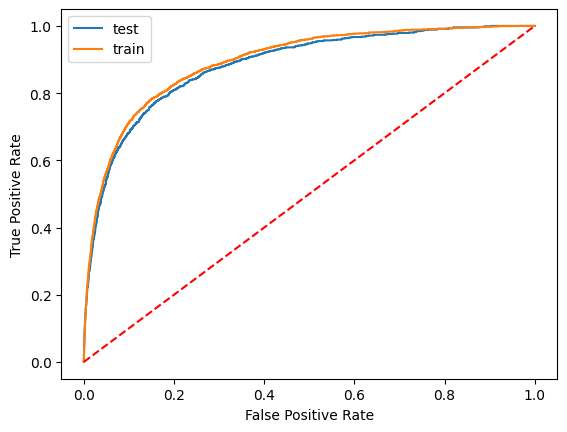

In [40]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
fpr_test, tpr_test, threshloads_test = roc_curve(enc_test['target'], enc_test['prediction'])
fpr_train, tpr_train, threshloads_train = roc_curve(enc_train['target'], enc_train['prediction'])
plt.plot(fpr_test, tpr_test, label='test')
plt.plot(fpr_train, tpr_train, label='train')
plt.plot([0, 1], [0, 1], '--', color='red')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

In [20]:
from reports.core import ReportBuilder

report = ReportBuilder(
    check_corr=True,
    check_features_stats=True,
    check_stats=True,
    check_features_scoring=True,
    check_model_score=True,
    check_psi=True,
    cv=3,
    class_weight="balanced",
    abs_corr=True,
    use_gini=True,
)


x_ = pd.concat([enc_train[(enc_train['rdate']<202210)], enc_test[(enc_test['rdate']<202210)]])[model_sfs.feature_names_].reset_index(drop=True)
y_ = pd.concat([enc_train[(enc_train['rdate']<202210)], enc_test[(enc_test['rdate']<202210)]])['target'].reset_index(drop=True)
dates_ = pd.concat([enc_train[(enc_train['rdate']<202210)], enc_test[(enc_test['rdate']<202210)]])["rdate"].reset_index(drop=True)
y_pred_ = pd.concat([enc_train[(enc_train['rdate']<202210)], enc_test[(enc_test['rdate']<202210)]])["prediction"].reset_index(drop=True)
 
report.fit(
    X=x_,
    y=y_,
    dates=dates_,
    y_pred=y_pred_,   
)



ReportBuilder(abs_corr=True, check_corr=True, check_features_scoring=True,
              check_features_stats=True, check_model_score=True, check_psi=True,
              check_stats=True, class_weight='balanced', use_gini=True)

In [21]:
#report.to_excel('report_1.xlsx') 
def to_excel(report, file_name: str = "") -> None:
    writer = pd.ExcelWriter(file_name, engine="xlsxwriter")
    for report in report.reports:
        if report is not None:
            report.to_excel(writer, sheet_name=report.name)
    writer.close()


In [22]:
to_excel(report, 'file_name.xlsx')

In [34]:
y_true_ = enc_train[(enc_train['rdate']<202210)]['target']
y_score_ = enc_train[(enc_train['rdate']<202210)]['prediction']
dates_ = enc_train[(enc_train['rdate']<202210)]['rdate']

roc_auc = roc_auc_score(y_true_, y_score_)
gini = (2 * roc_auc - 1) * 100     

gini_on_time_tr = model_scoring(
    y_true=y_true_,
    y_pred=y_score_, 
    dates=dates_,
    use_gini = True,
) 
gini_on_time_tr = gini_on_time_tr.rename(columns={'score': 'score_train'})
gini_on_time = gini_on_time.merge(gini_on_time_tr, how='left', on='date')

In [41]:
def dfs_tabs(df_list, sheet_list, file_name):
    writer = pd.ExcelWriter(file_name,engine='xlsxwriter')   
    for dataframe, sheet in zip(df_list, sheet_list):
        dataframe.to_excel(writer, sheet_name=sheet, startrow=0 , startcol=0)   
    writer.close()
def _calculate_psi_bins2(expected: pd.DataFrame, actual: pd.DataFrame) -> float:
    initial_counts = expected.value_counts()
    new_counts = actual.value_counts()

    df = pd.DataFrame({"Initial_Count": initial_counts, "New_Count": new_counts})

    df["Initial_Percent"] = df["Initial_Count"] / np.sum(df["Initial_Count"])
    df["Initial_Percent"] = df["Initial_Percent"].apply(
        lambda x: 0.0001 if x == 0 else x
    )
    df["New_Percent"] = df["New_Count"] / np.sum(df["New_Count"])
    df["New_Percent"] = df["New_Percent"].apply(lambda x: 0.0001 if x == 0 else x)
    df["PSI"] = (df["New_Percent"] - df["Initial_Percent"]) * np.log(
        df["New_Percent"] / df["Initial_Percent"]
    )
    psi_values = np.sum(df["PSI"] * 100)
    return psi_values
Corr_df = enc_train[model_sfs.feature_names_].corr(method='pearson').abs()
def calc_psi2(x: pd.DataFrame, dates: Union[pd.Series, np.ndarray]) -> pd.DataFrame:
    result_dict = {}
    for feature in x.columns:
        result_dict[feature] = []
 
        for date in sorted(np.unique(dates)):         
            result_dict[feature].append(
                _calculate_psi_bins2(

                    x[np.isin(dates, sorted(np.unique(dates)))][feature],   
                     
                    x[np.isin(dates, date)][feature],                            
                    )
            )
    result_df = pd.DataFrame.from_dict(result_dict)

    result_df["date"] = sorted(np.unique(dates))    
    result_df = result_df.set_index("date")
    return result_df.T

x_ = pd.concat([enc_train[(enc_train['rdate']<202210)], enc_test[(enc_test['rdate']<202210)]])[model_sfs.feature_names_].reset_index(drop=True)
dates_ = pd.concat([enc_train[(enc_train['rdate']<202210)], enc_test[(enc_test['rdate']<202210)]])["rdate"].reset_index(drop=True)  

psi_all_df2 = calc_psi2(x = x_, dates = dates_)
psi_2 = [psi_all_df2]
psi_sheets2 = ['PSI_oot_on_train']

def stability(
    x: pd.DataFrame,
    y: Union[pd.Series, np.ndarray],
    dates: Union[pd.Series, np.ndarray] = None,
    metric: str = "roc_auc",
    cv: int = 3,
    random_state: int = None,
    n_jobs: int = None,
    class_weight: str = None,
    use_gini: bool = False,
) -> pd.DataFrame:

    if dates is not None:
        dates = np.array(dates)
        result_dict = {
            "date": [],
            "feature": [],
            "score": [],
        }

    for feature in x.columns:
        if dates is not None:
            for date in sorted(np.unique(dates)):
                result_dict["date"].append(date)
                result_dict["feature"].append(feature)
                score = _calc_score(
                    x[np.isin(dates, date)][feature],
                    y[np.isin(dates, date)],
                    random_state=random_state,
                    class_weight=class_weight,
                    cv=cv,
                    metric=metric,
                    n_jobs=n_jobs,
                )
                if use_gini:
                    score = (2 * score - 1) * 100
                result_dict["score"].append(score)
    result_df = pd.DataFrame.from_dict(result_dict)
    if dates is not None:
        result_df = pd.pivot_table(
            result_df,
            values=["score"],
            columns=["date"],
            index=["feature"],
        )
    return result_df
x_ = pd.concat([enc_train[(enc_train['rdate']<202210)], enc_test[(enc_test['rdate']<202210)]])[model_sfs.feature_names_].reset_index(drop=True)
y_ = pd.concat([enc_train[(enc_train['rdate']<202210)], enc_test[(enc_test['rdate']<202210)]])['target'].reset_index(drop=True)
dates_ = pd.concat([enc_train[(enc_train['rdate']<202210)], enc_test[(enc_test['rdate']<202210)]])["rdate"].reset_index(drop=True)

Stability_df = stability(
          x=x_
        , y=y_
        , dates=dates_
        , use_gini=True)

dfs_psi_corr_stability = [
       psi_all_df2,
       Corr_df,
       Stability_df]

dfs_psi_corr_stability_sheets = [
       'PSI_oot_on_train',
       'Corr',
       'Stability']
 
dfs_tabs(dfs_psi_corr_stability, dfs_psi_corr_stability_sheets, '03_psi_corr_stability.xlsx')


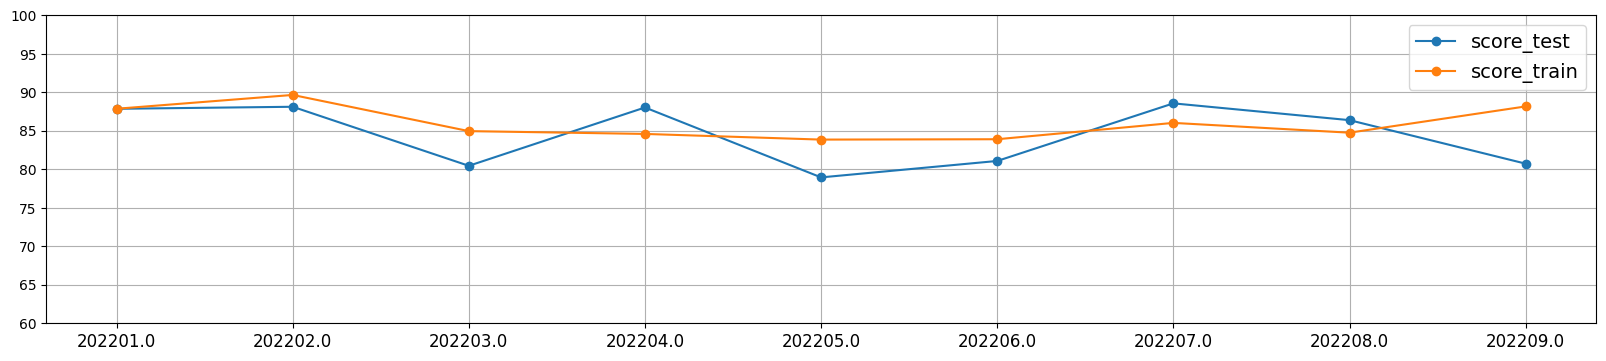

In [72]:
import matplotlib.pyplot as plt
df_gini_on_time = gini_on_time.reset_index() # так как график берет индекс за основу x-axis
del df_gini_on_time['index'] 

dates = gini_on_time['date']
fig, ax = plt.subplots(figsize=(20, 4))
ax.plot(df_gini_on_time.drop('date', axis=1), marker='o', label=df_gini_on_time.drop('date', axis=1).columns) 
ax.set_xticks(df_gini_on_time.index)  
ax.set_xticklabels(dates, fontsize=12) 
ax.set_ylim(60,100)
ax.legend(fontsize=14)
ax.grid()
fig.show()

In [53]:
#model_v.save_scorecard(encoder, 'model_summary.txt')
model_v.save_reports('model_summary.txt')

Problem with saving: [Errno 2] No such file or directory: 'model_summary.txt\\model_summary.txt'


In [ ]:
test_first.to_excel('test_clfrombroker_8bins_005mg_005th_tmp6(1500).xlsx')

In [ ]:
encoder.save_to_file("train_dict_v3.json")